In [3]:
import sys
import os
import numpy as np
import pydub
import pandas as pd

In [31]:
def extractZC( data, windowsizeinsamples, windowhopinsamples ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    numbersignchanges = []
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowhopinsamples)
        datasign = np.sign(data[windowstart:windowend])
        datasignderivative = datasign - np.roll(datasign,1)
        numbersignchanges.append(np.count_nonzero(datasignderivative[1:-1]))
    return np.array(numbersignchanges)

def extractSC( data, windowsizeinsamples, windowhopinsamples, samplerate ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    centroid = []
    freqs = np.arange(np.ceil(windowsizeinsamples/2.0)+1)*samplerate/windowsizeinsamples
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowsizeinsamples)
        DATA = np.abs(np.fft.fft(data[windowstart:windowend]))
        centroid.append(np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/
                        np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)]))
    return np.array(centroid)

def extractSV( data, windowsizeinsamples, windowhopinsamples, samplerate ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    variance = []
    freqs = np.arange(np.ceil(windowsizeinsamples/2.0)+1)*samplerate/windowsizeinsamples
    #freqs = np.power(freqs, trypower)
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowsizeinsamples)
        DATA = np.abs(np.fft.fft(data[windowstart:windowend]))  
        """ 
        centroid = np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])
            
        second_moment = np.sum(np.square(freqs)*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])
            
        variance.append( np.subtract(second_moment , centroid)
        """ 
        ind_max = int(np.ceil(windowsizeinsamples/2.0)+1) 
        centroid = np.sum(freqs*DATA[:ind_max])/np.sum(DATA[:ind_max])
        second_moment = np.sum(np.power(freqs, 2)*DATA[:ind_max])/np.sum(DATA[:ind_max])
        variance.append(second_moment - np.power(centroid,2))
    return np.array(variance)

In [34]:
def extract_features(path, frame_size_seconds, window_hop_seconds):
    """
    For some songs with shorter duration the arrays will be filled with -1's
    """
    duration = 60.02938776 # seconds per song. Shorter songs are accounted for later
    sample_rate = 44100
    windowsizeinsamples = frame_size_seconds * sample_rate
    windowhopinsamples =  window_hop_seconds * sample_rate   
    
    N_samples = 100
    N_frames = int(np.floor((duration*sample_rate-windowsizeinsamples)/windowhopinsamples))
    
    ZC_array = np.zeros((N_samples, N_frames))
    SC_array = np.zeros((N_samples, N_frames))
    SV_array = np.zeros((N_samples, N_frames))
    
    for file in os.scandir(path):
            
        if file.path.endswith(".mp3"):
            print("analyzing ", file.name, file.path)

            int_track = int(file.name[:-4])

            sound = pydub.AudioSegment.from_file(path + "/" + file.name, format = "mp3")  

            samples = sound.get_array_of_samples()

            ZC = extractZC( samples, windowsizeinsamples, windowhopinsamples )                                     
            SC = extractSC( samples, windowsizeinsamples, windowhopinsamples, sample_rate )
            SV = extractSV( samples, windowsizeinsamples, windowhopinsamples, sample_rate )
            
            if np.shape(ZC)[0] < N_frames:
                ZC = np.append(ZC, -1*np.ones(N_frames-np.shape(ZC)[0]))
                SC = np.append(SC, -1*np.ones(N_frames-np.shape(SC)[0]))
                SV = np.append(SV, -1*np.ones(N_frames-np.shape(SV)[0]))

            elif np.shape(ZC)[0] > N_frames:
                ZC = ZC[:N_frames]
                SC = SC[:N_frames]
                SV = SV[:N_frames]


            ZC_array[int_track-1, :] = ZC
            SC_array[int_track-1, :] = SC
            SV_array[int_track-1, :] = SV
            
    return ZC_array, SC_array, SV_array

In [40]:
path = "../data/emotifymusic/"
genres = ["classical", "electronic", "pop", "rock"]

ZC = []
SC = []
SV = []

for genre in genres:
    ZC_array, SC_array, SV_array = extract_features(path+genre, 0.100, 0.050)
    ZC.append(ZC_array)
    SC.append(SC_array)
    SV.append(SV_array)
    
# np.savez_compressed('zeroCrossings_frame100ms_hop50ms.npz', classical=ZC[0], electronic=ZC[1], pop=ZC[2], rock=ZC[3])
# np.savez_compressed('spectralCentroid_frame100ms_hop50ms.npz', classical=SC[0], electronic=SC[1], pop=SC[2], rock=SC[3])
# np.savez_compressed('spectralVariance_frame100ms_hop50ms.npz', classical=SV[0], electronic=SV[1], pop=SV[2], rock=SV[3])

analyzing  1.mp3 ../data/emotifymusic/classical\1.mp3
analyzing  10.mp3 ../data/emotifymusic/classical\10.mp3
analyzing  100.mp3 ../data/emotifymusic/classical\100.mp3
analyzing  11.mp3 ../data/emotifymusic/classical\11.mp3
analyzing  12.mp3 ../data/emotifymusic/classical\12.mp3
analyzing  13.mp3 ../data/emotifymusic/classical\13.mp3
analyzing  14.mp3 ../data/emotifymusic/classical\14.mp3
analyzing  15.mp3 ../data/emotifymusic/classical\15.mp3
analyzing  16.mp3 ../data/emotifymusic/classical\16.mp3
analyzing  17.mp3 ../data/emotifymusic/classical\17.mp3
analyzing  18.mp3 ../data/emotifymusic/classical\18.mp3
analyzing  19.mp3 ../data/emotifymusic/classical\19.mp3
analyzing  2.mp3 ../data/emotifymusic/classical\2.mp3
analyzing  20.mp3 ../data/emotifymusic/classical\20.mp3
analyzing  21.mp3 ../data/emotifymusic/classical\21.mp3
analyzing  22.mp3 ../data/emotifymusic/classical\22.mp3
analyzing  23.mp3 ../data/emotifymusic/classical\23.mp3
analyzing  24.mp3 ../data/emotifymusic/classical\2

C:\Users\Carsten\AppData\Local\Temp/ipykernel_17724/694790077.py:20: RuntimeWarning: invalid value encountered in double_scalars
  centroid.append(np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/
C:\Users\Carsten\AppData\Local\Temp/ipykernel_17724/694790077.py:41: RuntimeWarning: invalid value encountered in double_scalars
  centroid = np.sum(freqs*DATA[:ind_max])/np.sum(DATA[:ind_max])
C:\Users\Carsten\AppData\Local\Temp/ipykernel_17724/694790077.py:42: RuntimeWarning: invalid value encountered in double_scalars
  second_moment = np.sum(np.power(freqs, 2)*DATA[:ind_max])/np.sum(DATA[:ind_max])


analyzing  53.mp3 ../data/emotifymusic/classical\53.mp3
analyzing  54.mp3 ../data/emotifymusic/classical\54.mp3
analyzing  55.mp3 ../data/emotifymusic/classical\55.mp3
analyzing  56.mp3 ../data/emotifymusic/classical\56.mp3
analyzing  57.mp3 ../data/emotifymusic/classical\57.mp3
analyzing  58.mp3 ../data/emotifymusic/classical\58.mp3
analyzing  59.mp3 ../data/emotifymusic/classical\59.mp3
analyzing  6.mp3 ../data/emotifymusic/classical\6.mp3
analyzing  60.mp3 ../data/emotifymusic/classical\60.mp3
analyzing  61.mp3 ../data/emotifymusic/classical\61.mp3
analyzing  62.mp3 ../data/emotifymusic/classical\62.mp3
analyzing  63.mp3 ../data/emotifymusic/classical\63.mp3
analyzing  64.mp3 ../data/emotifymusic/classical\64.mp3
analyzing  65.mp3 ../data/emotifymusic/classical\65.mp3
analyzing  66.mp3 ../data/emotifymusic/classical\66.mp3
analyzing  67.mp3 ../data/emotifymusic/classical\67.mp3
analyzing  68.mp3 ../data/emotifymusic/classical\68.mp3
analyzing  69.mp3 ../data/emotifymusic/classical\6

analyzing  95.mp3 ../data/emotifymusic/electronic\95.mp3
analyzing  96.mp3 ../data/emotifymusic/electronic\96.mp3
analyzing  97.mp3 ../data/emotifymusic/electronic\97.mp3
analyzing  98.mp3 ../data/emotifymusic/electronic\98.mp3
analyzing  99.mp3 ../data/emotifymusic/electronic\99.mp3
analyzing  1.mp3 ../data/emotifymusic/pop\1.mp3
analyzing  10.mp3 ../data/emotifymusic/pop\10.mp3
analyzing  100.mp3 ../data/emotifymusic/pop\100.mp3
analyzing  11.mp3 ../data/emotifymusic/pop\11.mp3
analyzing  12.mp3 ../data/emotifymusic/pop\12.mp3
analyzing  13.mp3 ../data/emotifymusic/pop\13.mp3
analyzing  14.mp3 ../data/emotifymusic/pop\14.mp3
analyzing  15.mp3 ../data/emotifymusic/pop\15.mp3
analyzing  16.mp3 ../data/emotifymusic/pop\16.mp3
analyzing  17.mp3 ../data/emotifymusic/pop\17.mp3
analyzing  18.mp3 ../data/emotifymusic/pop\18.mp3
analyzing  19.mp3 ../data/emotifymusic/pop\19.mp3
analyzing  2.mp3 ../data/emotifymusic/pop\2.mp3
analyzing  20.mp3 ../data/emotifymusic/pop\20.mp3
analyzing  21.mp3

analyzing  61.mp3 ../data/emotifymusic/rock\61.mp3
analyzing  62.mp3 ../data/emotifymusic/rock\62.mp3
analyzing  63.mp3 ../data/emotifymusic/rock\63.mp3
analyzing  64.mp3 ../data/emotifymusic/rock\64.mp3
analyzing  65.mp3 ../data/emotifymusic/rock\65.mp3
analyzing  66.mp3 ../data/emotifymusic/rock\66.mp3
analyzing  67.mp3 ../data/emotifymusic/rock\67.mp3
analyzing  68.mp3 ../data/emotifymusic/rock\68.mp3
analyzing  69.mp3 ../data/emotifymusic/rock\69.mp3
analyzing  7.mp3 ../data/emotifymusic/rock\7.mp3
analyzing  70.mp3 ../data/emotifymusic/rock\70.mp3
analyzing  71.mp3 ../data/emotifymusic/rock\71.mp3
analyzing  72.mp3 ../data/emotifymusic/rock\72.mp3
analyzing  73.mp3 ../data/emotifymusic/rock\73.mp3
analyzing  74.mp3 ../data/emotifymusic/rock\74.mp3
analyzing  75.mp3 ../data/emotifymusic/rock\75.mp3
analyzing  76.mp3 ../data/emotifymusic/rock\76.mp3
analyzing  77.mp3 ../data/emotifymusic/rock\77.mp3
analyzing  78.mp3 ../data/emotifymusic/rock\78.mp3
analyzing  79.mp3 ../data/emotify

In [10]:
genres = ["classical", "electronic", "pop", "rock"]

ZCnpz = np.load('zeroCrossings_frame100ms_hop50ms.npz')
SCnpz = np.load('spectralCentroid_frame100ms_hop50ms.npz')
SVnpz = np.load('spectralVariance_frame100ms_hop50ms.npz')

ZC = []
SC = []
SV = []

for genre in genres:
    ZC.append(ZCnpz[genre])
    SC.append(SCnpz[genre])
    SV.append(SVnpz[genre])

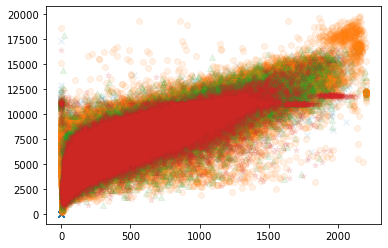

In [11]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.scatter(ZC[0].flatten(), SC[0].flatten(), marker='x', alpha=0.1)
ax.scatter(ZC[1].flatten(), SC[1].flatten(), marker='o', alpha=0.1)
ax.scatter(ZC[2].flatten(), SC[2].flatten(), marker='^', alpha=0.1)
ax.scatter(ZC[3].flatten(), SC[3].flatten(), marker='*', alpha=0.1)


# ax.set_xlim(0,10000)
# ax.set_ylim(0,20000)

(0.0, 150000000.0)

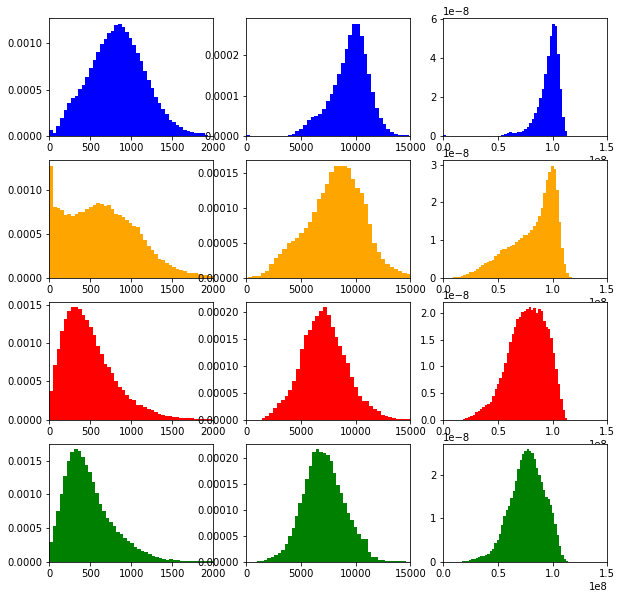

In [12]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(4,3, figsize=(10,10))

# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3)


ax1.hist(ZC[0].flatten(),  bins=50, density=True, color='blue')
ax2.hist(SC[0].flatten(),  bins=50, density=True, color='blue')
ax3.hist(SV[0].flatten(),  bins=50, density=True, color='blue')

ax4.hist(ZC[1].flatten(), bins=50, density=True, color='orange')
ax5.hist(SC[1].flatten(), bins=50, density=True, color='orange')
ax6.hist(SV[1].flatten(), bins=50, density=True, color='orange')

ax7.hist(ZC[2].flatten(),  bins=50, density=True, color='red')
ax8.hist(SC[2].flatten(),  bins=50, density=True, color='red')
ax9.hist(SV[2].flatten(),  bins=50, density=True, color='red')

ax10.hist(ZC[3].flatten(), bins=50, density=True, color='green')
ax11.hist(SC[3].flatten(), bins=50, density=True, color='green')
ax12.hist(SV[3].flatten(), bins=50, density=True, color='green')



ax1.set_xlim((0,2000))
ax4.set_xlim((0,2000))
ax7.set_xlim((0,2000))
ax10.set_xlim((0,2000))

ax2.set_xlim((0,15000))
ax5.set_xlim((0,15000))
ax8.set_xlim((0,15000))
ax11.set_xlim((0,15000))

ax3.set_xlim((0,1.5e8))
ax6.set_xlim((0,1.5e8))
ax9.set_xlim((0,1.5e8))
ax12.set_xlim((0,1.5e8))

In [26]:
ZC[0][:,:11]

array([[ 1.04339e+05,  1.24615e+05,  1.06826e+05, ...,  1.62533e+05,
         1.54691e+05, -1.00000e+00],
       [ 2.31381e+05,  2.42082e+05,  2.49753e+05, ...,  2.67617e+05,
         2.74778e+05, -1.00000e+00],
       [ 1.07301e+05,  1.52715e+05,  1.43826e+05, ...,  1.56643e+05,
         1.35939e+05, -1.00000e+00],
       ...,
       [ 1.90905e+05,  1.61352e+05,  1.75243e+05, ...,  1.88110e+05,
         1.92156e+05, -1.00000e+00],
       [ 1.98531e+05,  2.27180e+05,  1.96905e+05, ...,  1.97024e+05,
         2.01334e+05, -1.00000e+00],
       [ 1.92079e+05,  1.98964e+05,  1.87276e+05, ...,  1.75498e+05,
         1.85350e+05, -1.00000e+00]])

In [39]:
ZC_5_2 = ZC
SC_5_2 = SC
SV_5_2 = SV

(0.0, 150000000.0)

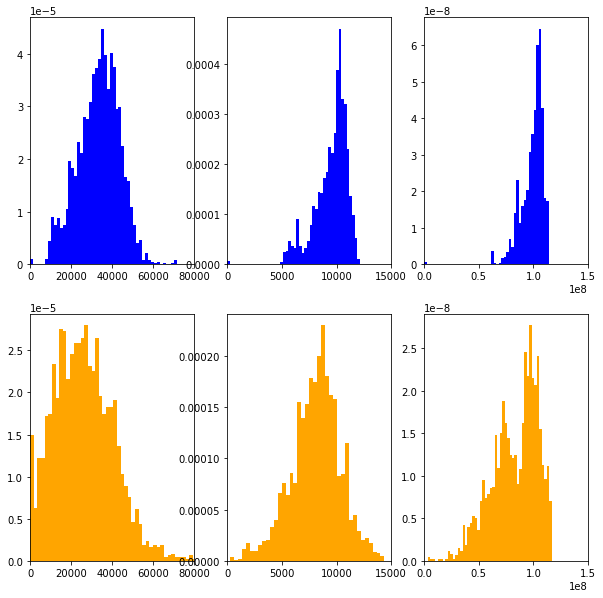

In [54]:
# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(4,3, figsize=(10,10))

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3,  figsize=(10,10))


ax1.hist(ZC_5_2[0].flatten(),  bins=50, density=True, color='blue')
ax2.hist(SC_5_2[0].flatten(),  bins=50, density=True, color='blue')
ax3.hist(SV_5_2[0].flatten(),  bins=50, density=True, color='blue')

ax4.hist(ZC_5_2[1].flatten(), bins=50, density=True, color='orange')
ax5.hist(SC_5_2[1].flatten(), bins=50, density=True, color='orange')
ax6.hist(SV_5_2[1].flatten(), bins=50, density=True, color='orange')

# ax7.hist(ZC_5_2[2].flatten(),  bins=50, density=True, color='red')
# ax8.hist(SC_5_2[2].flatten(),  bins=50, density=True, color='red')
# ax9.hist(SV_5_2[2].flatten(),  bins=50, density=True, color='red')

# ax10.hist(ZC_5_2[3].flatten(), bins=50, density=True, color='green')
# ax11.hist(SC_5_2[3].flatten(), bins=50, density=True, color='green')
# ax12.hist(SV_5_2[3].flatten(), bins=50, density=True, color='green')

ax1.set_xlim((0,80000))
ax4.set_xlim((0,80000))
ax2.set_xlim((0,15000))
ax5.set_xlim((0,15000))
ax3.set_xlim((0,1.5e8))
ax6.set_xlim((0,1.5e8))

(0.0, 150000000.0)

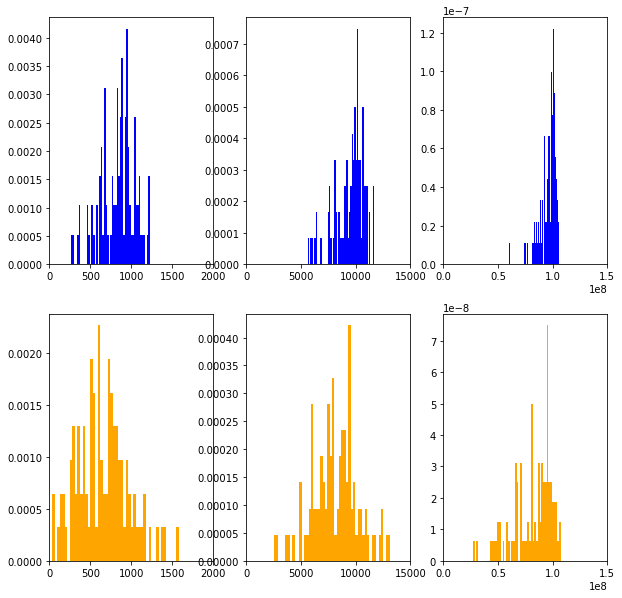

In [69]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3,  figsize=(10,10))


ZC_means0 = np.mean(ZC[0], axis=1)
ZC_means1 = np.mean(ZC[1], axis=1)

SC_means0 = np.mean(SC[0], axis=1)
SC_means1 = np.mean(SC[1], axis=1)

SV_means0 = np.mean(SV[0], axis=1)
SV_means1 = np.mean(SV[1], axis=1)


ax1.hist(ZC_means0,  bins=50, density=True, color='blue')
ax2.hist(SC_means0,  bins=50, density=True, color='blue')
ax3.hist(SV_means0,  bins=50, density=True, color='blue')

ax4.hist(ZC_means1, bins=50, density=True, color='orange')
ax5.hist(SC_means1, bins=50, density=True, color='orange')
ax6.hist(SV_means1, bins=50, density=True, color='orange')


# ax2.hist(SC[0][song,:],  bins=50, density=True, color='blue')
# ax3.hist(SV[0][song,:],  bins=50, density=True, color='blue')

# ax4.hist(ZC_means1, bins=50, density=True, color='orange')
# ax5.hist(SC[1][song,:], bins=50, density=True, color='orange')
# ax6.hist(SV[1][song,:], bins=50, density=True, color='orange')

ax1.set_xlim((0,2000))
ax4.set_xlim((0,2000))
ax2.set_xlim((0,15000))
ax5.set_xlim((0,15000))
ax3.set_xlim((0,1.5e8))
ax6.set_xlim((0,1.5e8))

Text(0.5, 0.98, 'classical')

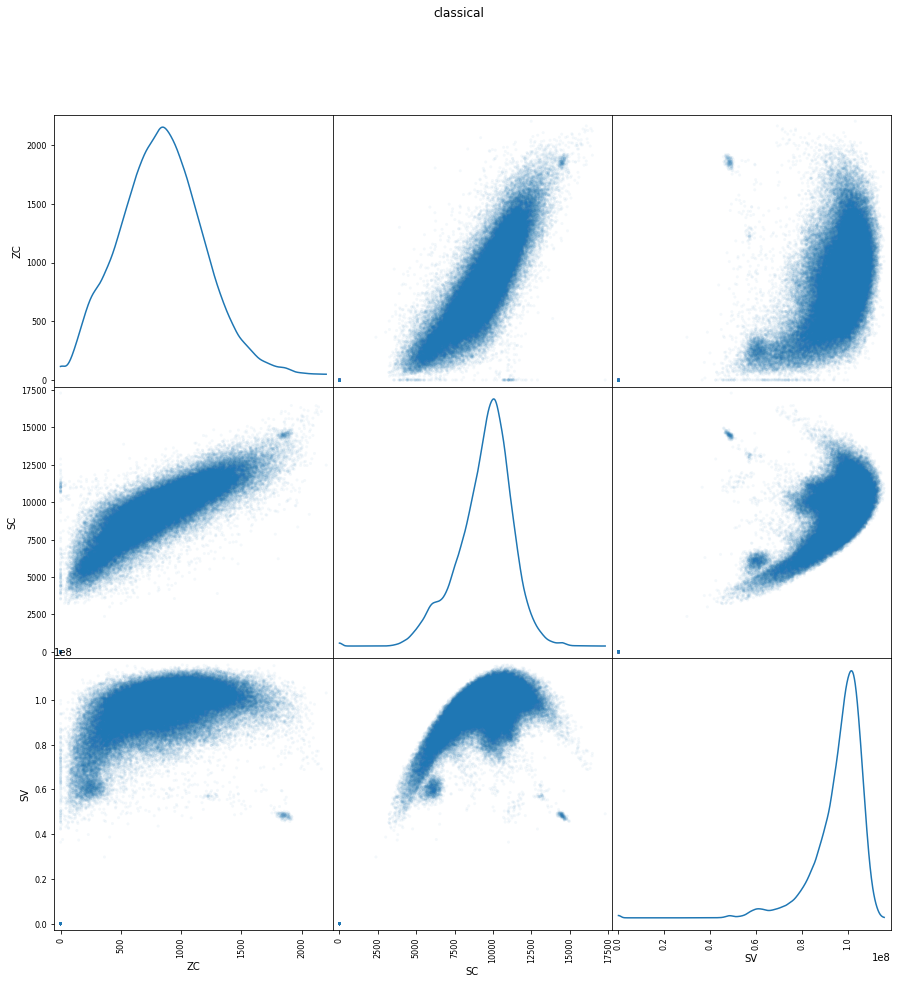

In [47]:
C_dict = {'ZC': ZC[0].flatten(), 'SC': SC[0].flatten(), 'SV': SV[0].flatten()}
C_df = pd.DataFrame(C_dict)
pd.plotting.scatter_matrix(C_df, alpha=0.05, figsize=(15,15), diagonal = 'kde')
plt.suptitle('classical')

# SC_dict = {'classical': SC[0].flatten(), 'electronic': SC[1].flatten(), 'pop': SC[2].flatten(), 'rock': SC[3].flatten()}
# SC_df = pd.DataFrame(SC_dict)
# pd.plotting.scatter_matrix(SC_df, alpha=0.05, figsize=(15,15), diagonal = 'kde')
# plt.suptitle('spectral centroid')

# SV_dict = {'classical': SV[0].flatten(), 'electronic': SV[1].flatten(), 'pop': SV[2].flatten(), 'rock': SV[3].flatten()}
# SV_df = pd.DataFrame(SV_dict)
# pd.plotting.scatter_matrix(SV_df, alpha=0.05, figsize=(15,15), diagonal = 'kde')
# plt.suptitle('spectral variance')

In [53]:
np.shape(np.array(ZC))

(4, 100, 1198)